<a href="https://colab.research.google.com/github/mgetsova/GoogleCollab/blob/main/CNN_smaller_cifar10_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
    

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# for some reason I only have CPU sooo...idk, going to try to use less data
# here for instructive purposes anyway

# device will determine whether to run the training on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
'''
step 1: download and initialize dataset
'''
# import CIFAR-10 dataset from huggingface
from datasets import load_dataset
dataset_train = load_dataset(
    'cifar10',
    split = 'train', # training dataset
    ignore_verifications = True # set to True if seeing splits Error
)
dataset_train

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2562: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [6]:
type(dataset_train)

datasets.arrow_dataset.Dataset

In [7]:
 import random
 indices = random.sample(range(dataset_train.num_rows), k=1000)

In [8]:
'''
the dataset is an arrow type object and you can see how you can
subset based on row indicies or label filters (which can be useful)
here: https://stackoverflow.com/questions/72891947/how-do-you-get-a-subset-of-a-python-arrow-dataset-dataset-based-on-a-list-of-ind
'''

#subset_dataset_train = dataset_train.select(range(5000)) # selects rows with idx up to 5000?
subset_dataset_train = dataset_train.select(indices) # selects rows with idx in indices

In [9]:
print(subset_dataset_train.shape) # cool, seems to work!

(1000, 2)


In [10]:
# get validation dataset
dataset_val = load_dataset(
    'cifar10',
    split = 'test', # test dataset
    ignore_verifications = True # set to True if seeing splits Error
)
dataset_val

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2562: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [11]:
# use only the first 1000 images for validation set
subset_dataset_val = dataset_val.select(random.sample(range(dataset_val.num_rows), k=200))

In [12]:
# set all images to same size:
img_size = 32

# preprocess variable, to be used ahead
preprocess = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])


In [13]:
# change any greyscale images to RGB, using subset now,
# why not just make it a function tbh
from tqdm.auto import tqdm

inputs_train = []

for record in tqdm(subset_dataset_train):
  image = record['img']
  label = record['label']

  # convert from greyscale to RGB
  if image.mode == 'L':
    image = image.convert("RGB")

  # preprocessing
  input_tensor = preprocess(image)

  # append to batch list
  inputs_train.append([input_tensor, label])

# now we have 32x32 pixel RGB images (3d tensor with dims 3, 32, 32)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
# get mean and std values for each of the RGB channels accross all images
import numpy as np

np.random.seed(0)

# calculate the mean and std of images, first start by choosing a random
# sample ?
idx = np.random.randint(0, len(inputs_train), 512)
# concatenate this subset of image tensors
tensors = torch.concat([inputs_train[i][0] for i in idx], axis = 1)
# we get a tensor with dims (3, 16384 (this is 512x32), 32) so
# like 512 stacked images?

# merge all values into a single 3-channel vector
tensors = tensors.swapaxes(0, 1).reshape(3, -1).T
# we get a tensor with dims (524288 (this is 512x32x32), 3) which is just
# weird but doesn't matter because we delete it
mean = torch.mean(tensors, axis = 0)
std = torch.std(tensors, axis = 0)
del tensors


# now use the mean [0.4670, 0.4735, 0.4662] and the std [0.2496, 0.2489, 0.2521]
# to normalize via another preprocessing step

preprocess = transforms.Compose([transforms.Normalize(mean=mean, std=std)])
for i in tqdm(range(len(inputs_train))):
  # preprocessing
  input_tensor = preprocess(inputs_train[i][0])

  # append to batch list
  inputs_train[i][0] = input_tensor # replace with normalized tensor

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
# we kinda wanna do the same thing for the validation set
# Usually you would want to merge the preprocessing steps together :
preprocess = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
# except the one above has the normalize part?

# same as before:
inputs_val = []

for record in tqdm(subset_dataset_val):
  image = record['img']
  label = record['label']

  # convert from greyscale to RGB
  if image.mode == 'L':
    image = image.convert("RGB")

  # preprocessing
  input_tensor = preprocess(image)

  # append to batch list
  inputs_val.append([input_tensor, label])

  0%|          | 0/200 [00:00<?, ?it/s]

In [16]:
batch_size = 64

# Use DataLoader to split both the training and validation dataset into shuffled
# batches. Shuffle helps prevent overfitting
dloader_train = torch.utils.data.DataLoader(
    inputs_train, batch_size = batch_size, shuffle = True
)
dloader_val = torch.utils.data.DataLoader(
    inputs_val, batch_size = batch_size, shuffle = False
)


# so up until this point we have been doing preprocessing on forms of the data
# that all follow from the dataset_train and dataset_val, and we probably want
# to try using only every 10th image in each of those to speed up
# experimentation


**Building the CNN's Architecture**

In [17]:
# creating a CNN class:
class ConvNeuralNet(nn.Module):
  def __init__(self, num_classes):
    super(ConvNeuralNet, self).__init__()
    self.conv_layer1 = nn.Conv2d(in_channels = 3, out_channels = 64,
                                 kernel_size = 4, padding = 1)
    self.relu1 = nn.ReLU()
    self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)

    self.conv_layer2 = nn.Conv2d(in_channels = 64, out_channels = 192,
                                 kernel_size = 4, padding = 1)
    self.relu2 = nn.ReLU()
    self.max_pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)

    self.conv_layer3 = nn.Conv2d(in_channels = 192, out_channels = 384,
                                 kernel_size = 3, padding = 1)
    self.relu3 = nn.ReLU()

    self.conv_layer4 = nn.Conv2d(in_channels = 384, out_channels = 256,
                                kernel_size = 3, padding = 1)
    self.relu4 = nn.ReLU()

    self.conv_layer5 = nn.Conv2d(in_channels = 256, out_channels = 256,
                                 kernel_size = 3, padding = 1)
    self.relu5 = nn.ReLU()
    self.max_pool5 = nn.MaxPool2d(kernel_size = 3, stride = 2)

    self.dropout6 = nn.Dropout(p = 0.5)
    self.fc6 = nn.Linear(1024, 512)
    self.relu6 = nn.ReLU()
    self.dropout7 = nn.Dropout(p=0.5)
    self.fc7 = nn.Linear(512, 256)
    self.relu7 = nn.ReLU()
    self.fc8 = nn.Linear(256, num_classes)

  # progress data acress layers, this basically
  # defines the order in which the above operations are
  # done
  def forward(self, x):
    out = self.conv_layer1(x)
    out = self.relu1(out)
    out = self.max_pool1(out)

    out = self.conv_layer2(out)
    out = self.relu2(out)
    out = self.max_pool2(out)

    out = self.conv_layer3(out)
    out = self.relu3(out)

    out = self.conv_layer4(out)
    out = self.relu4(out)

    out = self.conv_layer5(out)
    out = self.relu5(out)
    out = self.max_pool5(out)

    out = out.reshape(out.size(0), -1)

    out = self.dropout6(out)
    out = self.fc6(out)
    out = self.relu6(out)

    out = self.dropout7(out)
    out = self.fc7(out)
    out = self.relu7(out)

    out = self.fc8(out) # final logits
    return out


In [18]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(set(subset_dataset_train['label']))
model = ConvNeuralNet(num_classes).to(device)

In [19]:
# set loss function with criterion
loss_func = nn.CrossEntropyLoss()

# set learning rate
lr = 0.008

# set optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

See how long each epoch takes on the reduced dataset sizes below:

Not sure if can run both models at the same time without running out of RAM...
Yes but val accuracy was not changing so it seems something about the way we selected the first 10th of each dataset may be problematic

Also, it still takes over an hour, try larger batch size and/or fewer epochs maybe (iirc, it does number of batches per epoch so 64 sets of randomly selected subsets of the images for training per epoch)

In [20]:
# train an valiate the network
num_epochs = 50
for epoch in range(num_epochs):
  model.train()
  # load in the data in batches
  for i, (images, labels) in enumerate(dloader_train):
    # send images and labels to device
    # move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    # forward propagation
    outputs = model(images)
    loss = loss_func(outputs, labels)

    # backward propagation and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # the end of the epoch check validation loss and accuracy on validation
  with torch.no_grad():
      # switch to evaluating the model and not training it
    model.eval()
    correct = 0
    total = 0
    all_val_loss = []
    for images, labels in dloader_val:
      iamges = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      total += labels.size(0)
      # calcualte predictions
      predicted = torch.argmax(outputs, dim = 1)
      # calculate actual values
      correct += (predicted == labels).sum().item()
      # calculate the loss
      all_val_loss.append(loss_func(outputs, labels).item())
    # calculate val-loss
    mean_val_loss = sum(all_val_loss) / len(all_val_loss)
    # calculate val-accuracy
    mean_val_acc = 100 * (correct / total)

  print(
      'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc:{:.2f}'
      .format(epoch + 1, num_epochs, loss.item(), mean_val_loss, mean_val_acc)
  )

Epoch [1/50], Loss: 2.2967, Val-loss: 2.3091, Val-acc:9.50
Epoch [2/50], Loss: 2.2950, Val-loss: 2.3089, Val-acc:9.50
Epoch [3/50], Loss: 2.3076, Val-loss: 2.3087, Val-acc:9.50
Epoch [4/50], Loss: 2.3129, Val-loss: 2.3085, Val-acc:9.50
Epoch [5/50], Loss: 2.3081, Val-loss: 2.3082, Val-acc:9.50
Epoch [6/50], Loss: 2.2960, Val-loss: 2.3081, Val-acc:10.50
Epoch [7/50], Loss: 2.3011, Val-loss: 2.3079, Val-acc:10.50
Epoch [8/50], Loss: 2.3031, Val-loss: 2.3077, Val-acc:10.50
Epoch [9/50], Loss: 2.2985, Val-loss: 2.3075, Val-acc:10.50
Epoch [10/50], Loss: 2.2985, Val-loss: 2.3074, Val-acc:10.50
Epoch [11/50], Loss: 2.3019, Val-loss: 2.3072, Val-acc:10.50
Epoch [12/50], Loss: 2.3019, Val-loss: 2.3071, Val-acc:10.50
Epoch [13/50], Loss: 2.3086, Val-loss: 2.3069, Val-acc:10.50
Epoch [14/50], Loss: 2.3047, Val-loss: 2.3068, Val-acc:10.50
Epoch [15/50], Loss: 2.3009, Val-loss: 2.3066, Val-acc:10.50
Epoch [16/50], Loss: 2.3059, Val-loss: 2.3065, Val-acc:10.50
Epoch [17/50], Loss: 2.2990, Val-loss:

In [21]:
# save to file
torch.save(model, 'cnn.pt')
# load from file and switch to inference mode
model = torch.load('cnn.pt')
model.eval()

ConvNeuralNet(
  (conv_layer1): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(64, 192, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv_layer4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (conv_layer5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (max_pool5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout6): Dropout(p=0.5, inplace=False)
  (fc6): Linear(in_features=1024, out_features=512, bias=True)
  (relu6): ReLU()
  (dropout7): Dropout(p=0.5, inplace=False)
  (fc7): Linear(in_features=512, ou

**Inference**

In [25]:
input_tensors = []
for image in subset_dataset_val['img'][:10]:
    tensor = preprocess(image)
    input_tensors.append(tensor.to(device))

In [26]:
# we have 10 tensors
len(input_tensors)

10

In [27]:
# all 32x32 dimensional with 3 color channels
input_tensors[0].shape

torch.Size([3, 32, 32])

In [28]:
# stack into a single tensor
input_tensors = torch.stack(input_tensors)
input_tensors.shape

torch.Size([10, 3, 32, 32])

In [29]:
# process through model to get output logits
outputs = model(input_tensors)
# calculate predictions
predicted = torch.argmax(outputs, dim=1)
predicted

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [31]:
# here are the class names
dataset_val.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

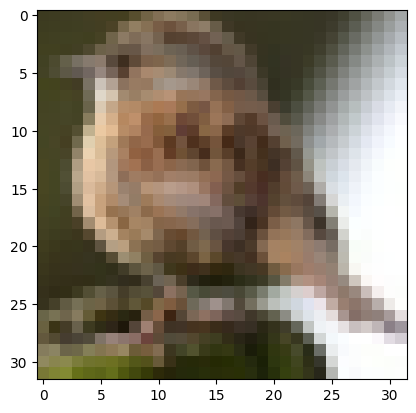

deer


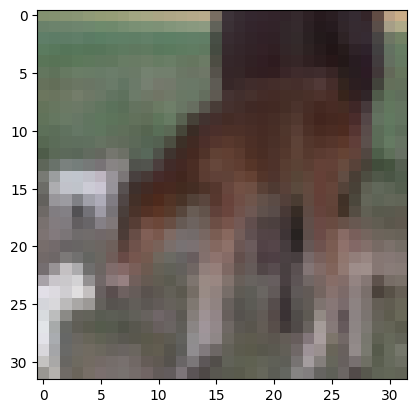

deer


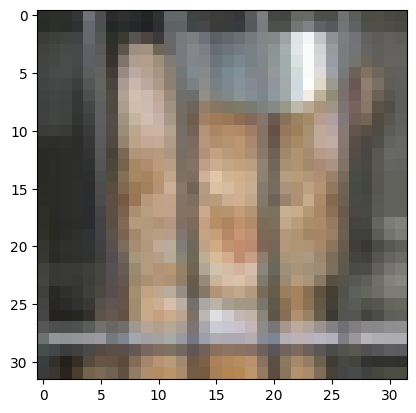

deer


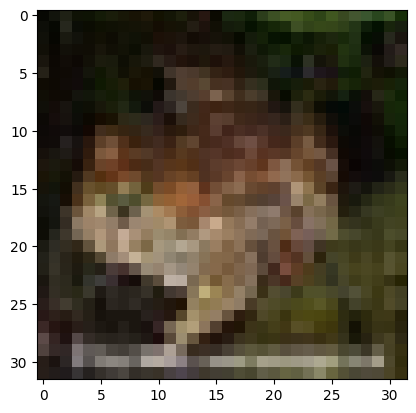

deer


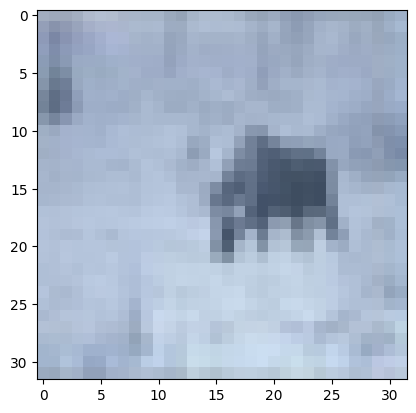

deer


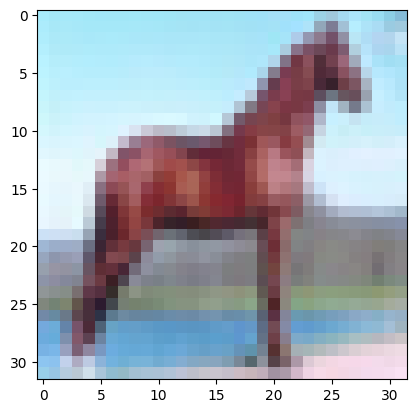

deer


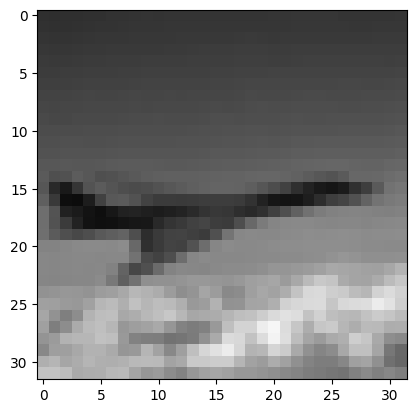

deer


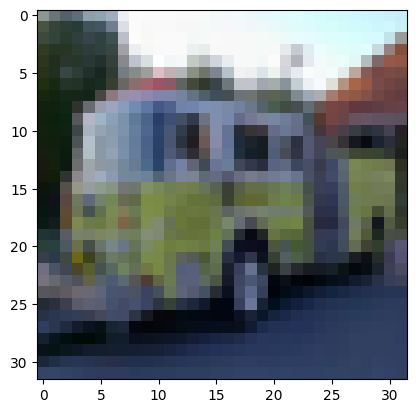

deer


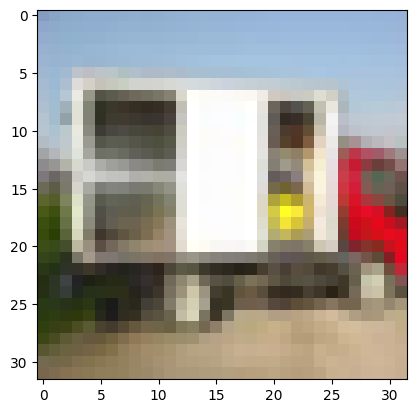

deer


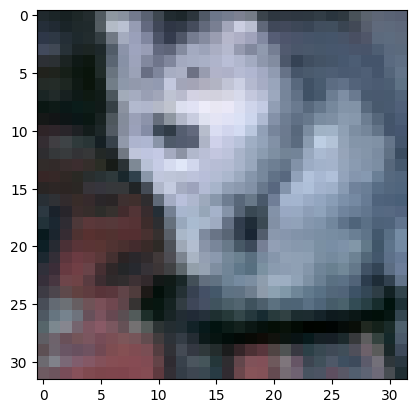

deer


In [34]:
# so the predictions are bad --- everything is deer

import matplotlib.pyplot as plt

for i, image in enumerate(subset_dataset_val['img'][:10]):
    plt.imshow(image)
    plt.show()
    print(subset_dataset_val.features['label'].names[predicted[i]])